Importamos las librerías $\texttt{numpy}$ y $\texttt{matplotlib}$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# Definición de funciones

Definimos la función *malla_círculo*, la cual recibe como parámetros dos enteros positivos *m* y *n*, siendo el primero la cantidad de círculos concéntricos que se usarán en la malla, y el segundo la cantidad de cortes transversales que se harán en la malla, es decir *n-1* es el número de trozos.

In [3]:
def malla_circulo(m,n):
    malla = np.empty((m,n))
    return malla

Para los cálculos posteriores y sin pérdida de generalidad consideraremos que los radios en la malla toman los valores $r\in\left\{\frac{1}{m},\frac{2}{m},\ldots,1\right\}$, mientras que los ángulos serán $\theta\in\left\{0,\frac{2\pi}{n},\frac{2\pi}{n}\cdot2,\ldots,\frac{2\pi}{n}(n-1)\right\}$ 

La función *est_var_ang* estima el variograma angular según la siguiente fórmula:
\begin{equation}
\hat{\gamma^*}\left(\theta_k=\frac{2\pi}{n}k\right)=\frac{1}{mn}\sum_{r=1}^m\sum_{i=0}^{n-1}\left(X\left(rA\left(\frac{2k\pi}{n}(i+1)\right)\mathbf{e}\right)-X\left(rA\left(\frac{2k\pi}{n}i\right)\mathbf{e}\right)\right)^2,
\end{equation}
donde $k<n$.

In [4]:
def est_var_ang(malla,k):
    m = np.size(malla,0)
    n = np.size(malla,1)
    est = 0
    for r in range(m):
        for i in range(n):
            est += (malla[r,(i+k)%n]-malla[r,i])**2
    return est/(2*m*n)

La función *est_var_ang_cr* estima el variograma angular cruzado según la fórmula
\begin{equation}
\hat{\gamma^*}_{XY}\left(\theta_k=\frac{2\pi}{n}k\right)=\frac{1}{mn}\sum_{r=1}^m\sum_{i=0}^{n-1}\left(X\left(rA\left(\frac{2k\pi}{n}(i+1)\right)\mathbf{e}\right)-X\left(rA\left(\frac{2k\pi}{n}i\right)\mathbf{e}\right)\right)\left(Y\left(rA\left(\frac{2k\pi}{n}(i+1)\right)\mathbf{e}\right)-Y\left(rA\left(\frac{2k\pi}{n}i\right)\mathbf{e}\right)\right),
\end{equation}
donde $k<n$.

Si las dimensiones de las mallas no son las mismas, se informa y no se calcula nada.

In [5]:
def est_var_ang_cr(malla_1, malla_2, k):
    m_1 = np.size(malla_1,0)
    n_1 = np.size(malla_1,1)
    m_2 = np.size(malla_2,0)
    n_2 = np.size(malla_2,1)
    if (m_1 == m_2) and (n_1 == n_2):
        est = 0
        for r in range(m_1):
            for i in range(n_1):
                est += (malla_1[r,(i+k)%n]-malla_1[r,i])*(malla_2[r,(i+k)%n]-malla_2[r,i])
        return est/(2*m_1*n_1)
    else:
        print("Las dimensiones de las mallas no coinciden")

La función *est_pseudovar_ang_cr* estima el pseudovariograma angular cruzado utilizando la siguiente fórmula:
\begin{equation}
\hat{\gamma^{c*}}_{XY}\left(\theta_k=\frac{2\pi}{n}k\right)=\frac{1}{mn}\sum_{r=1}^m\sum_{i=0}^{n-1}\left(X\left(rA\left(\frac{2k\pi}{n}(i+1)\right)\mathbf{e}\right)-Y\left(rA\left(\frac{2k\pi}{n}i\right)\mathbf{e}\right)\right)^2,
\end{equation}
donde $k>n$.

Si las dimensiones de las mallas no son las mismas, se informa y no se calcula nada.

In [6]:
def est_pseudovar_ang_cr(malla_1, malla_2, k):
    m_1 = np.size(malla_1,0)
    n_1 = np.size(malla_1,1)
    m_2 = np.size(malla_2,0)
    n_2 = np.size(malla_2,1)
    if (m_1 == m_2) and (n_1 == n_2):
        est = 0
        for r in range(m_1):
            for i in range(n_1):
                est += (malla_1[r,(i+k)%n]-malla_2[r,i])**2
        return est/(m_1*n_1)
    else:
        print("Las dimensiones de las mallas no coinciden")

In [7]:
def est_covar_ang_cr(malla_1, malla_2, k):
    m_1 = np.size(malla_1,0)
    n_1 = np.size(malla_1,1)
    m_2 = np.size(malla_2,0)
    n_2 = np.size(malla_2,1)
    if (m_1 == m_2) and (n_1 == n_2):
        est = 0
        media_1 = np.mean(malla_1)
        media_2 = np.mean(malla_2)
        for r in range(m_1):
            for i in range(n_1):
                est += (malla_1[r,i]-media_1)*(malla_2[r,(i+k)%n]-media_2)
        return est/(m_1*n_1)
    else:
        print("Las dimensiones de las mallas no coinciden")

Definimos la función *plot_malla* la cual grafica la malla con sus correspondientes valores en una escala de grises.

In [8]:
def plot_malla(malla):
    m = np.size(malla,0)
    n = np.size(malla,1)
    
    coord_r = [(i+1)/m for i in range(m)]
    coord_a = [2*np.pi*i/n for i in range(n)]

    coord = np.empty((m*n,2))
    colors = np.empty(m*n)

    contador = 0
    for r in range(m):
        for i in range(n):
            coord[contador,:] = np.array([coord_r[r], coord_a[i]])
            colors[contador] = malla[r,i]
            contador += 1
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='polar')
    c = ax.scatter(coord[:,1], coord[:,0], c = colors, cmap = 'binary')

La función *plot_var_ang* dibuja la curva generada al calcular el variograma angular en función del ángulo.

In [9]:
def var_ang(malla):
    n = np.size(malla,1)
    list_var = list()
    
    ang = list()

    for i in range(n):
        list_var.append(est_var_ang(malla,i+1))
        ang.append(2*np.pi*(i+1)/n)
    
    return list_var

Análogamente, *plot_var_ang_cr* grafica la curva que se obtiene al calcular el variograma angular cruzado utilizando diferentes valores de $k$.

In [10]:
def plot_var_ang_cr(malla_1, malla_2):
    n_1 = np.size(malla_1,1)
    n_2 = np.size(malla_2,1)
    
    ang = list()
    
    if n_1 == n_2:
        list_var = list()
        for i in range(n-1):
            list_var.append(est_var_ang_cr(malla_1,malla_2,i+1))
            ang.append(2*np.pi*(i+1)/n)
        fig = plt.figure()
        plt.plot(ang,list_var)
        plt.ylim((-3,0.5))
        plt.xlabel("Ángulo [rad]")
        plt.ylabel("Variograma cruzado")
        plt.title("Variograma cruzado malla AR(1)")
        plt.show()
        return list_var
    else:
        print("Las dimensiones de las mallas no coinciden")

Asimismo, *plot_pseudovar_ang_cr* dibuja el pseudovariograma angular cruzado en función del ángulo.

In [11]:
def plot_pseudovar_ang_cr(malla_1, malla_2):
    n_1 = np.size(malla_1,1)
    n_2 = np.size(malla_2,1)
    
    ang = list()
    
    if n_1 == n_2:
        list_var = list()
        for i in range(n-1):
            list_var.append(est_pseudovar_ang_cr(malla_1,malla_2,i+1))
            ang.append(2*np.pi*(i+1)/n)
        plt.plot(ang,list_var)
        return list_var
    else:
        print("Las dimensiones de las mallas no coinciden")

In [12]:
def plot_covar_ang_cr(malla_1, malla_2):
    n_1 = np.size(malla_1,1)
    n_2 = np.size(malla_2,1)
    
    ang = list()
    
    if n_1 == n_2:
        list_var = list()
        for i in range(n-1):
            list_var.append(est_covar_ang_cr(malla_1,malla_2,i+1))
            ang.append(2*np.pi*(i+1)/n)
        plt.plot(ang,list_var)
        return list_var
    else:
        print("Las dimensiones de las mallas no coinciden")

In [13]:
def plot_codisp_ang_cr(malla_1, malla_2):
    n_1 = np.size(malla_1,1)
    n_2 = np.size(malla_2,1)
    
    ang = list()
    
    if n_1 == n_2:
        list_var = list()
        for i in range(n-1):
            if est_var_ang(malla_1,i+1)*est_var_ang(malla_2,i+1) == 0:
                print('¡Denominador nulo!')
            list_var.append(est_var_ang_cr(malla_1,malla_2,i+1)/np.sqrt(est_var_ang(malla_1,i+1)**2*est_var_ang(malla_2,i+1)**2))
            ang.append(2*np.pi*(i+1)/n)
        plt.plot(ang,list_var)
        return list_var
    else:
        print("Las dimensiones de las mallas no coinciden")

*rotar_malla* recibe una malla y devuelve su rotación en el ángulo *rot*.

In [14]:
def rotar_malla(malla, rot):
    m = np.size(malla,0)
    n = np.size(malla,1)
    
    if rot < n:
        malla_rot = np.empty((m,n))
        malla_rot[:,rot:] = malla[:,:-rot]
        malla_rot[:,:rot] = malla[:,-rot:]
        return malla_rot
    else:
        print("No es posible rotar en el ángulo "+str(2*np.pi*rot/n))

# Ejemplos

En primer lugar, fijamos valores para $m$ y $n$, los cuales serán utilizados para todos los ejemplos.

In [15]:
m = 18
n = 360

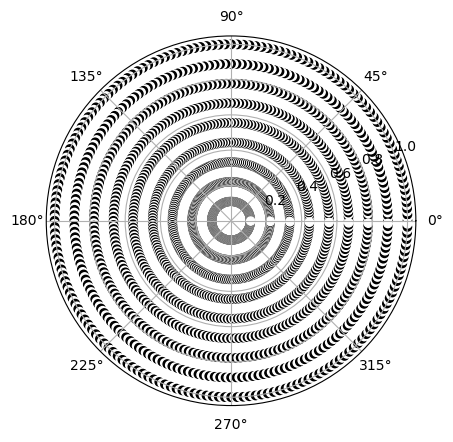

In [15]:
malla_ej = np.zeros((m,n))

for i in range(n):
    for r in range(m):
        if i%2==0:
            if r%2==1:
                malla_ej[r,i] = 1

plot_malla(malla_ej)

In [17]:
est_var_ang(malla_ej,1)

0.25

In [18]:
rot = 30

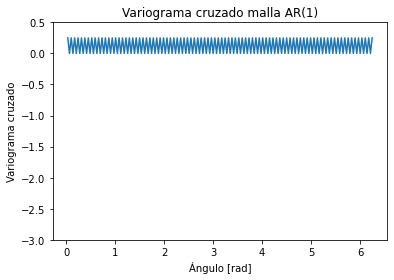

Ángulo de rotación efectivo: 0.6555555555555556

Valor mínimo:0.0
Índice: 1
Ángulo: 0.022222222222222223

Valor mínimo:0.0
Índice: 2
Ángulo: 0.03333333333333333


In [19]:
valores = plot_var_ang_cr(malla_ej, rotar_malla(malla_ej,rot))

print('Ángulo de rotación efectivo: '+str(2*(59)/n)+'\n')
ind_min = valores.index(min(valores))
print('Valor mínimo:' +str(valores[ind_min])+'\nÍndice: '+str(ind_min)+'\nÁngulo: '+str(2*(ind_min+1)/n)+'\n')
valores.remove(valores[ind_min])
ind_2_min = valores.index(min(valores))
print('Valor mínimo:' +str(valores[ind_2_min])+'\nÍndice: '+str(ind_2_min)+'\nÁngulo: '+str(2*(ind_2_min+1)/n))

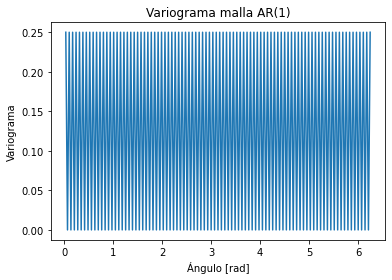

0.25

In [20]:
plot_var_ang(malla_ej)[0]

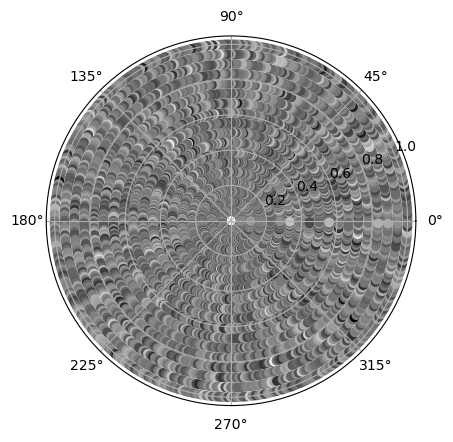

In [16]:
malla_norm = np.random.normal(0,1,size=(m,n))

plot_malla(malla_norm)

In [19]:
est_var_ang_cr(rotar_malla(malla_norm,rot), malla_norm,rot)

-0.5128843893343583

In [20]:
est_var_ang(malla_norm,2*rot)/2

0.5148474855449241

In [21]:
est_var_ang(malla_norm,rot)

1.0277318748792812

In [22]:
est_var_ang(malla_norm,2*rot)/2-est_var_ang(malla_norm,rot)

-0.5128843893343571

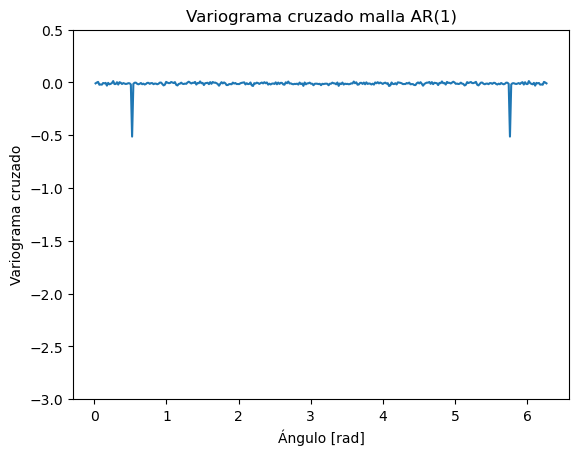

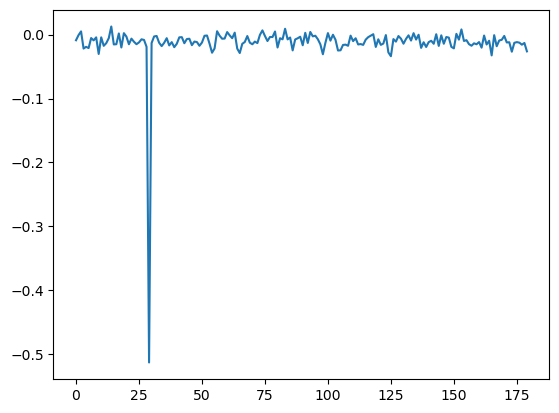

In [72]:
plt.plot(plot_var_ang_cr(malla_norm, rotar_malla(malla_norm, 30))[:180])

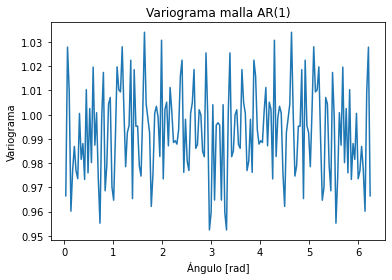

0.9665106548095498

In [32]:
plot_var_ang(malla_norm)[0]

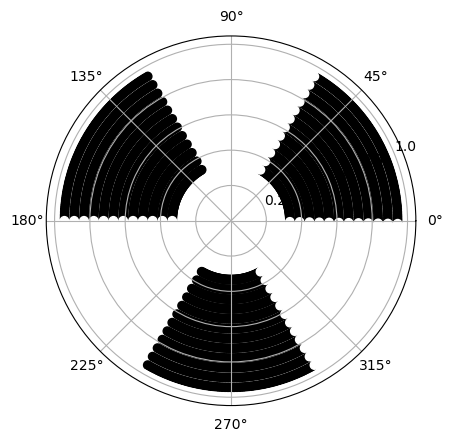

In [15]:
toxic_malla = np.zeros((m,n))

for r in range(m-6):
    for i in range(n//6):
        toxic_malla[r+5,i] = 1
        toxic_malla[r+5,i+(n//6)*2] = 1
        toxic_malla[r+5,i+(n//6)*4] = 1

plot_malla(toxic_malla)

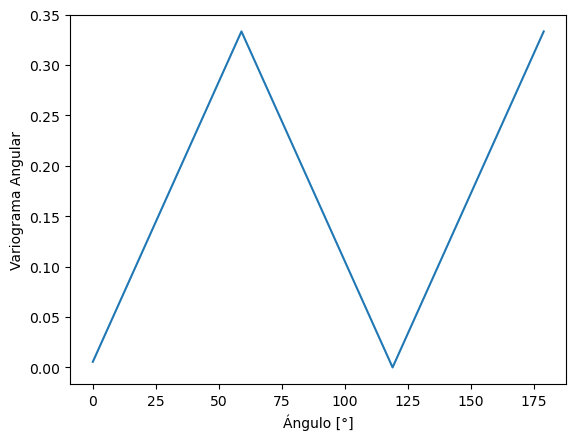

In [23]:
plt.xlabel("Ángulo [°]")
plt.ylabel("Variograma Angular")
plt.plot(var_ang(toxic_malla)[:180])

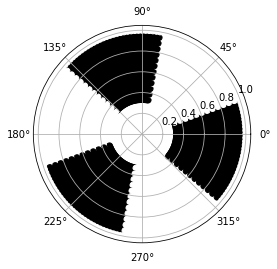

In [34]:
plot_malla(rotar_malla(toxic_malla,100))

In [17]:
valores = plot_var_ang_cr(toxic_malla, rotar_malla(toxic_malla,rot))

print('Ángulo de rotación efectivo: '+str(2*(59)/n)+'\n')
ind_min = valores.index(min(valores))
print('Valor mínimo:' +str(valores[ind_min])+'\nÍndice: '+str(ind_min)+'\nÁngulo: '+str(2*(ind_min+1)/n)+'\n')
valores.remove(valores[ind_min])
ind_2_min = valores.index(min(valores))
print('Valor mínimo:' +str(valores[ind_2_min])+'\nÍndice: '+str(ind_2_min)+'\nÁngulo: '+str(2*(ind_2_min+1)/n))

NameError: name 'rot' is not defined

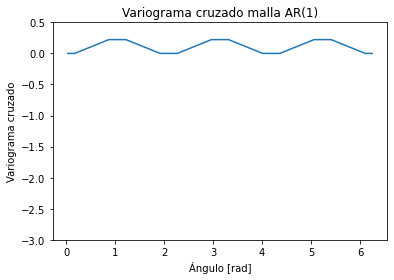

0.0

In [36]:
plot_var_ang_cr(toxic_malla, rotar_malla(toxic_malla,55))[0]

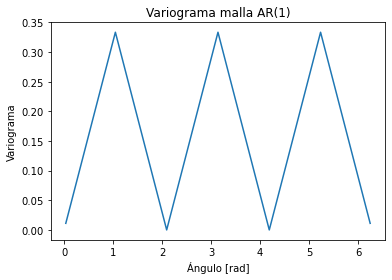

0.011111111111111112

In [38]:
plot_var_ang(toxic_malla)[0]

In [33]:
def ar_sim(n, param):
    p = len(param)
    coef = np.empty(p+1)
    coef[0] = 1
    coef[1:] = -np.array(param)
    roots = np.polynomial.Polynomial(coef).roots()
    norm_roots = [np.linalg.norm(roots[i]) for i in range(p)]
    for i in norm_roots:
        assert i > 1
    
    data = [np.random.normal(0,1) for i in range(p)]
    for i in range(n-p):
        datarev = [data[-i] for i in range(1,p+1)]
        data.append(np.dot(param,datarev) + np.random.normal(0,1))
    return data

In [79]:
malla_autoc = np.empty((m,n))

for i in range(m):
    malla_autoc[i,:] = ar_sim(n,[0.9])

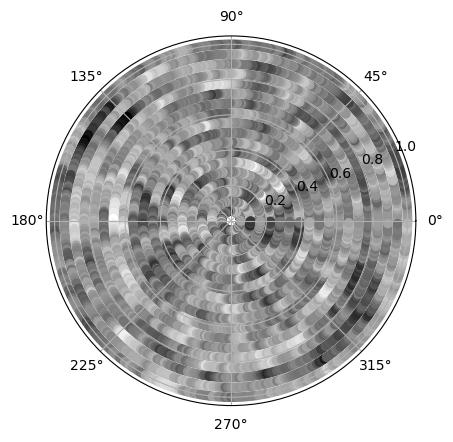

In [80]:
plot_malla(malla_autoc)

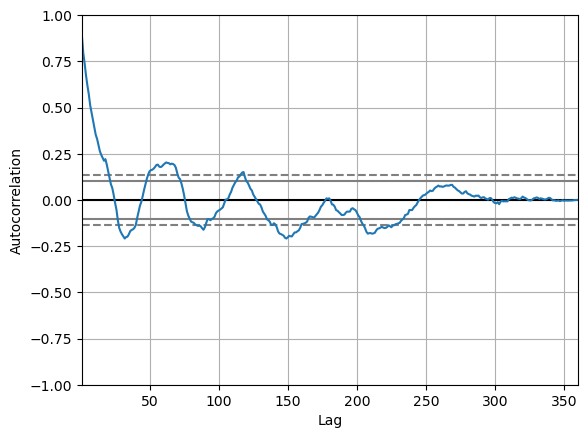

In [81]:
x = pd.plotting.autocorrelation_plot(pd.Series(malla_autoc[2]))

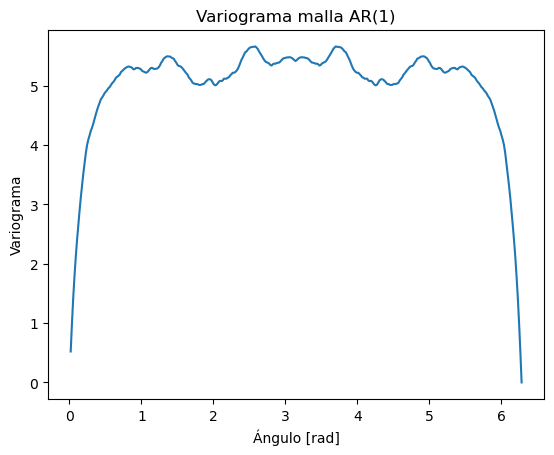

In [82]:
ar1 = plot_var_ang(malla_autoc)[:180]

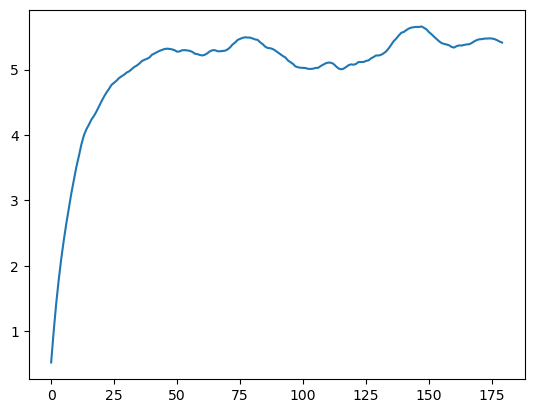

In [83]:
plt.plot(ar1)

In [85]:
ar1_teo = [(1-0.9**t)/(1-0.9**2) for t in range(180)]

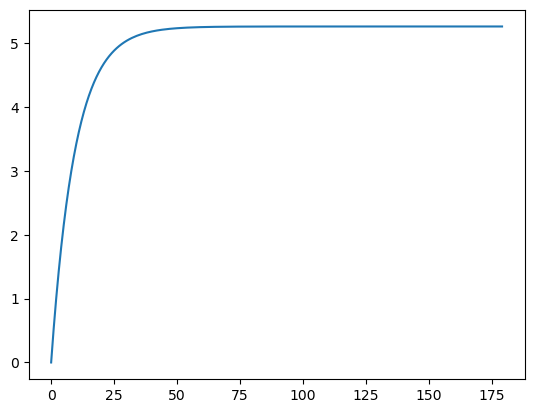

In [86]:
plt.plot(ar1_teo)

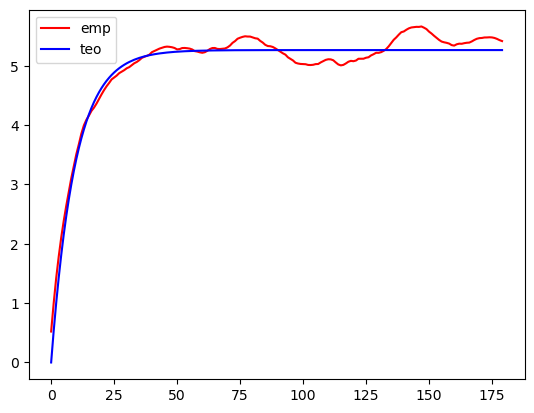

In [88]:
plt.figure()
plt.plot(ar1, color='red', label='emp')
plt.plot(ar1_teo, color='blue', label='teo')
plt.legend()
plt.show()